# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler

from utils import cont_variables, increase_stringency_CSF, preprocess

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature data set (brain elevated)

In [3]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")
# drop non-sequence-based features
df_features.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## Human Proteome

In [4]:
df_human_proteome = pd.read_csv(data_path + "/Features/df_features.csv")
# drop non-sequence-based features
df_human_proteome.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## CSF data set

In [5]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

# Remove AD biomarkers

References for AD biomarker list:
- Molinuevo JL, Ayton S, Batrla R, Bednar MM, Bittner T, Cummings J, et al. Current state of Alzheimer’s fluid biomarkers. Acta Neuropathol. 2018 Dec;136(6):821–53. https://doi.org/10.1007/s00401-018-1932-x
- Zetterberg H, Bendlin BB. Biomarkers for Alzheimer’s disease—preparing for a new era of disease-modifying therapies. Mol Psychiatry. 2021 Jan;26(1):296–308. https://doi.org/10.1038/s41380-020-0721-9
- Leuzy A, Cullen NC, Mattsson-Carlgren N, Hansson O. Current advances in plasma and cerebrospinal fluid biomarkers in Alzheimer’s disease. Current Opinion in Neurology. 2021 Apr;34(2):266–74. https://doi.org/10.1097/WCO.0000000000000904

In [6]:
# create dictionary of known AD biomarkers
biomarker_dict = {"P05067": "APP", 
                  "P10636": "MAPT", 
                  "P07196": "NfL",
                  "P62760": "VLP-1", 
                  "P05413": "HFABP",
                  "P36222": "YKL-40", 
                  "P14136": "GFAP", 
                  "Q92686": "Neurogranin", 
                  "P21579": "Synaptotagmin",
                  "P60880": "SNAP25",
                  "P17677": "Neuromodulin/GAP43",
                  "P47972": "NPTX2",
                  "P56817": "BACE1", 
                  "P02778": "IP-10",                   
                  "Q9NZC2": "TREM2",
                  "Q7L0J3": "SV2A", 
                  "P30536": "TSPO"
                  }

print("Number of AD biomarker proteins:", len(biomarker_dict))
print("Number of AD biomarker proteins to exclude from feature data set:", 
    len(df_features[df_features["Uniprot"].isin(biomarker_dict.keys())]))

Number of AD biomarker proteins: 17
Number of AD biomarker proteins to exclude from feature data set: 13


In [7]:
df_features = increase_stringency_CSF(df_features, csf, 3)

df_features_no_AD_biomarker = df_features[~df_features["Uniprot"].isin(biomarker_dict.keys())]
print("Number of proteins in filtered feature data set:", len(df_features_no_AD_biomarker))
print("\tCSF proteins:", df_features_no_AD_biomarker["CSF"].value_counts()[1])
print("\tnon-CSF proteins:", df_features_no_AD_biomarker["CSF"].value_counts()[-1])

Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
Number of proteins in filtered feature data set: 1700
	CSF proteins: 513
	non-CSF proteins: 1187


# Machine Learning

## Data set preprocessing

In [8]:
# define variables and target
X = df_features_no_AD_biomarker.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_features_no_AD_biomarker["CSF"]

print("Number of features:", len(X.columns))

Number of features: 52


In [9]:
# scale continuous variables
scaler = RobustScaler()
X_scal = X.copy()
X_scal[cont_variables] = scaler.fit_transform(X_scal[cont_variables])

# balance classes by undersampling
X_bal, y_bal = RandomUnderSampler(random_state=0).fit_resample(X_scal, y)

## Model training

In [10]:
# use same parameters as trained model 
clf_AD = LogisticRegressionCV(penalty="l1", solver="liblinear", Cs=[0.5], scoring="roc_auc", max_iter=1000, 
    random_state=0).fit(X_bal, y_bal)

print("ROC-AUC of test set: %.4f" %(np.mean(clf_AD.scores_[1], axis=0)[0]))

ROC-AUC of test set: 0.8925


In [11]:
coef_dict_HC = {}

for i, col in enumerate(X.columns):
    coef_dict_HC[col] = clf_AD.coef_[0][i]
    
coef_series_HC = pd.Series(coef_dict_HC).sort_values()
print("Number of included model features:", len(coef_series_HC[coef_series_HC != 0]))
print("--------------------------")
coef_series_HC.sort_values(ascending=False, key=abs, inplace=True)
print("Most important features and their coefficients")
print(coef_series_HC[:20])

Number of included model features: 38
--------------------------
Most important features and their coefficients
Nucleus                 -2.492172
Golgi_apparatus          1.970868
Signal peptide           1.785206
PredHel_binary           0.705768
Extracellular            0.697302
Cytoplasm               -0.673134
PS00022                  0.594336
G                        0.526328
L                       -0.488412
Helix_NSP               -0.461822
Peroxisome              -0.407287
R                       -0.407057
I                       -0.405604
Isoelectric point       -0.360705
Sheet_NSP                0.347934
K                        0.343631
H                       -0.335206
S                       -0.323513
W                       -0.315884
Endoplasmic_reticulum    0.292396
dtype: float64


## Prediction on AD biomarkers

In [12]:
df_pred = df_human_proteome.copy()

# define variables and target
X = df_pred.drop(["Uniprot", "Sequence", "CSF"], axis=1)

# preprocess data with same scaler as training data
X_scal = X.copy()
print(scaler)
X_scal[cont_variables] = scaler.transform(X_scal[cont_variables])

RobustScaler()


In [13]:
# predict on full human proteome
proba = clf_AD.predict_proba(X_scal)

# add probabilities to dataframe
proba_df = pd.DataFrame(proba, columns=["non_CSF", "CSF"])
df_pred["Score"] = proba_df["CSF"]

# subset AD biomarkers
biomarkers_pred = df_pred[df_pred["Uniprot"].isin(biomarker_dict.keys())]
biomarkers_pred = biomarkers_pred.sort_values(by="Score", ascending=False)

In [14]:
for biomarker in biomarkers_pred["Uniprot"]:
    print(biomarker_dict[biomarker], "%.04f" \
    % df_pred[df_pred["Uniprot"] == biomarker]["Score"].values[0])

Neuromodulin/GAP43 0.9913
Neurogranin 0.9758
NPTX2 0.9617
APP 0.9561
BACE1 0.9518
Synaptotagmin 0.9360
HFABP 0.9324
MAPT 0.8920
YKL-40 0.8886
IP-10 0.8551
TREM2 0.8250
SNAP25 0.5399
VLP-1 0.4352
NfL 0.3796
SV2A 0.2978
GFAP 0.1390
TSPO 0.0935


In [15]:
# create dictionary of biomarker function
function_dict = {"P05067": "A\u03B2 pathology", # APP
              "P10636": "Tau pathology", # MAPT
              "P07196": "Neuronal injury", # NfL
              "P62760": "Neuronal injury", # VLP-1
              "P05413": "Vascular dysregulation", # HFABP
              "P36222": "Inflammation", # YKL-40
              "P14136": "Neuronal injury", #GFAP
              "Q92686": "Synaptic dysfunction", # Neurogranin
              "P21579": "Synaptic dysfunction", # Synaptotagmin
              "P60880": "Synaptic dysfunction", # SNAP25
              "P17677": "Synaptic dysfunction", # Neuromodulin
              "P47972": "Synaptic dysfunction", # NPTX2
              "P56817": "A\u03B2 pathology", # BACE1
              "P02778": "Inflammation", # IP-10                 
              "Q9NZC2": "Inflammation", # TREM2
              "Q7L0J3": "PET biomarker", # SV2A
              "P30536": "PET biomarker" # TSPO
              }
   
function_df = pd.DataFrame.from_dict(function_dict, orient="index").reset_index() 
function_df.columns = ["Uniprot", "Biomarker_category"]

# merge biomarker dataframe with function column
biomarkers_pred = biomarkers_pred.merge(function_df, on="Uniprot", how="inner")

In [16]:
# manually determine legend labels by sorting dataframe based on functioncategory
custom_dict = {"A\u03B2 pathology": 0, "Tau pathology": 1, "Synaptic dysfunction": 2, "Inflammation": 3,
               "Vascular dysregulation": 4, "Neuronal injury": 5, "PET biomarker":6}

biomarkers_pred.sort_values(by=["Biomarker_category"], key=lambda x: x.map(custom_dict), inplace=True)

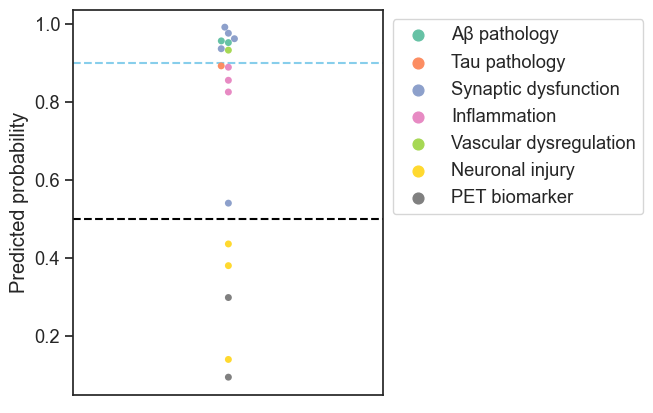

In [17]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(4,5))

sns.swarmplot(data=biomarkers_pred, x=[0]*len(biomarkers_pred), y="Score", hue="Biomarker_category",
             palette=sns.color_palette("Set2", 6) + ["grey"])
ax.set(ylabel="Predicted probability", xticks=[], xticklabels=[])
ax.axhline(0.5, color="black", linestyle="--")
ax.axhline(0.9, color="skyblue", linestyle="--")
ax.legend(bbox_to_anchor=(1,1)) 

plt.show()
fig.savefig(fig_path + "Probability_AD_CSF_biomarkers.png", bbox_inches="tight", dpi=300, transparent=True)